# Modelagem Preditiva - Previsão de Gravidade de Ocorrências

## Notebook 03 - Fase de Modelagem

**Objetivo:** Construir e avaliar um modelo de Machine Learning capaz de classificar uma ocorrência aeronáutica como **Grave** (Acidente ou Incidente Grave) ou **Não Grave** (Incidente).

**Metodologia:**
1.  **Preparação dos Dados:** Seleção de features, criação da variável alvo e tratamento final de nulos.
2.  **Pré-processamento:** Transformação de variáveis categóricas em numéricas (One-Hot Encoding).
3.  **Treinamento e Avaliação:** Divisão dos dados em treino e teste, treinamento de um modelo de classificação (ex: RandomForest) e avaliação de sua performance.

In [2]:
# Instalação das bibliotecas
!pip install -q pandas matplotlib seaborn scikit-learn

# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configurações de visualização
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Carregando o DataFrame mestre que preparamos
df = pd.read_csv('data/cenipa_master.csv', sep=';', encoding='utf-8')

print("Ambiente configurado e dados carregados.")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Ambiente configurado e dados carregados.


### 1. Preparação de Dados para o Modelo

Nesta etapa, vamos criar o `DataFrame` específico para a modelagem.

1.  **Seleção de Features (X):** Escolhemos as variáveis preditivas com base nos insights da EDA, tomando cuidado para não usar informações que só estariam disponíveis após o evento (evitando *data leakage*).
2.  **Criação da Variável Alvo (y):** Transformamos a `ocorrencia_classificacao` em uma variável binária (`0` = Não Grave, `1` = Grave).
3.  **Limpeza Final:** Removemos as linhas com dados ausentes nas colunas selecionadas para garantir a qualidade dos dados de entrada do modelo.

In [3]:
print("--- Iniciando a preparação dos dados para modelagem ---")

# 1. Selecionando as features (X) que não causam vazamento de dados
features_selecionadas = [
    'ocorrencia_classificacao', # Usada para criar o alvo
    'ocorrencia_uf',
    'aeronave_tipo_veiculo',
    'aeronave_motor_tipo',
    'aeronave_registro_segmento',
    'aeronave_fase_operacao'
]

df_modelo = df[features_selecionadas].copy()


# 2. Criando a variável alvo (y)
df_modelo['alvo_gravidade'] = df_modelo['ocorrencia_classificacao'].apply(
    lambda x: 0 if x == 'INCIDENTE' else 1
)
df_modelo.drop(columns=['ocorrencia_classificacao'], inplace=True)


# 3. Limpeza Final de Nulos
df_modelo.dropna(inplace=True)


# --- RESULTADO ---
print("DataFrame para modelagem criado com sucesso!")
print(f"Formato do DataFrame: {df_modelo.shape}")

print("\nDistribuição da nossa variável alvo (0 = Não Grave, 1 = Grave):")
print(df_modelo['alvo_gravidade'].value_counts())

print("\nVisualizando as 5 primeiras linhas do DataFrame de modelagem:")
display(df_modelo.head())

--- Iniciando a preparação dos dados para modelagem ---
DataFrame para modelagem criado com sucesso!
Formato do DataFrame: (20102, 6)

Distribuição da nossa variável alvo (0 = Não Grave, 1 = Grave):
alvo_gravidade
1    11892
0     8210
Name: count, dtype: int64

Visualizando as 5 primeiras linhas do DataFrame de modelagem:


,ocorrencia_uf,aeronave_tipo_veiculo,aeronave_motor_tipo,aeronave_registro_segmento,aeronave_fase_operacao,alvo_gravidade
3,RS,AVIÃO,TURBOÉLICE,NAO INFORMADO,DECOLAGEM,0
4,SP,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0
6,CE,AVIÃO,JATO,NAO INFORMADO,SUBIDA,0
7,SP,AVIÃO,JATO,NAO INFORMADO,CRUZEIRO,0
8,AL,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0


### 1.1. Ajustes Finais no DataFrame de Modelagem

Antes de avançar para o pré-processamento, vamos realizar dois ajustes finais no `DataFrame` para garantir sua consistência e qualidade:

1.  **Revisão da Estratégia de Imputação:** Vamos analisar a proporção de valores `NAO INFORMADO` na coluna `aeronave_registro_segmento` para validar a decisão de mantê-la como uma categoria. A manutenção desta categoria é importante para evitar a perda de um volume significativo de dados e permitir que o modelo aprenda com a própria ausência de informação.
2.  **Reset do Índice:** Após a remoção de linhas com dados nulos, o índice do `DataFrame` ficou não-sequencial. Vamos resetá-lo para uma sequência limpa (0, 1, 2, ...), o que é uma boa prática para a etapa de modelagem.

In [8]:
print("--- Realizando ajustes finais no df_modelo ---")

# 1. Analisando a proporção de 'NAO INFORMADO'
print("Distribuição e proporção da coluna 'aeronave_registro_segmento':")
# Usamos normalize=True para ver o resultado em percentual
segmento_proporcao = df_modelo['aeronave_registro_segmento'].value_counts(normalize=True) * 100
display(segmento_proporcao)
print(f"\nA categoria 'NAO INFORMADO' corresponde a {segmento_proporcao.get('NAO INFORMADO', 0):.2f}% do nosso dataset de modelagem.")


# 2. Resetando o índice
df_modelo.reset_index(drop=True, inplace=True)
print("\nÍndice do DataFrame resetado com sucesso.")


# --- RESULTADO ---
print("\nVisualizando as 5 primeiras linhas do DataFrame com o índice corrigido:")
display(df_modelo.head())

--- Realizando ajustes finais no df_modelo ---
Distribuição e proporção da coluna 'aeronave_registro_segmento':


aeronave_registro_segmento
PARTICULAR                27.141578
REGULAR                   16.097901
INSTRUÇÃO                 13.292210
NAO INFORMADO             13.152920
TÁXI AÉREO                11.217789
AGRÍCOLA                   7.879813
EXPERIMENTAL               4.138892
ADMINISTRAÇÃO DIRETA       3.293205
ESPECIALIZADA              2.586807
MÚLTIPLA                   0.462641
NÃO REGULAR                0.383046
ADMINISTRAÇÃO INDIRETA     0.338275
HISTÓRICA                  0.014924
Name: proportion, dtype: float64


A categoria 'NAO INFORMADO' corresponde a 13.15% do nosso dataset de modelagem.

Índice do DataFrame resetado com sucesso.

Visualizando as 5 primeiras linhas do DataFrame com o índice corrigido:


,ocorrencia_uf,aeronave_tipo_veiculo,aeronave_motor_tipo,aeronave_registro_segmento,aeronave_fase_operacao,alvo_gravidade
0,RS,AVIÃO,TURBOÉLICE,NAO INFORMADO,DECOLAGEM,0
1,SP,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0
2,CE,AVIÃO,JATO,NAO INFORMADO,SUBIDA,0
3,SP,AVIÃO,JATO,NAO INFORMADO,CRUZEIRO,0
4,AL,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0


### 2. Pré-processamento: Transformando Categorias em Números (One-Hot Encoding)

Com nosso DataFrame de modelagem finalizado e validado, o próximo passo é converter suas variáveis categóricas em um formato numérico que os algoritmos de Machine Learning possam processar.

Para isso, utilizaremos a técnica de **One-Hot Encoding**. Este processo cria novas colunas binárias (com valores 0 ou 1) para cada categoria possível em uma coluna original. Isso permite que o modelo entenda as categorias sem atribuir uma ordem ou peso indevido a elas.

In [9]:
print("--- Iniciando o processo de One-Hot Encoding ---")

# 1. Separando as features (X) da nossa variável alvo (y)
X = df_modelo.drop('alvo_gravidade', axis=1)
y = df_modelo['alvo_gravidade']

print(f"Formato original das features (X): {X.shape}")

# 2. Aplicando o One-Hot Encoding com a função get_dummies do Pandas
# O drop_first=True remove a primeira categoria de cada feature, evitando multicolinearidade, o que é uma boa prática
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

print(f"Formato das features após o One-Hot Encoding (X_encoded): {X_encoded.shape}")


# --- RESULTADO ---
print("\nVisualizando as 5 primeiras linhas do DataFrame de features codificado:")
display(X_encoded.head())

--- Iniciando o processo de One-Hot Encoding ---
Formato original das features (X): (20102, 5)
Formato das features após o One-Hot Encoding (X_encoded): (20102, 85)

Visualizando as 5 primeiras linhas do DataFrame de features codificado:


,ocorrencia_uf_AC,ocorrencia_uf_AL,ocorrencia_uf_AM,ocorrencia_uf_AP,ocorrencia_uf_BA,ocorrencia_uf_CE,ocorrencia_uf_DF,ocorrencia_uf_ES,ocorrencia_uf_GO,ocorrencia_uf_MA,ocorrencia_uf_MG,ocorrencia_uf_MS,ocorrencia_uf_MT,ocorrencia_uf_PA,ocorrencia_uf_PB,ocorrencia_uf_PE,ocorrencia_uf_PI,ocorrencia_uf_PR,ocorrencia_uf_RJ,ocorrencia_uf_RN,ocorrencia_uf_RO,ocorrencia_uf_RR,ocorrencia_uf_RS,ocorrencia_uf_SC,ocorrencia_uf_SE,ocorrencia_uf_SP,ocorrencia_uf_TO,aeronave_tipo_veiculo_ANFÍBIO,aeronave_tipo_veiculo_AVIÃO,aeronave_tipo_veiculo_BALÃO,aeronave_tipo_veiculo_DIRIGÍVEL,aeronave_tipo_veiculo_GIROCÓPTERO,aeronave_tipo_veiculo_HELICÓPTERO,aeronave_tipo_veiculo_HIDROAVIÃO,aeronave_tipo_veiculo_PLANADOR,aeronave_tipo_veiculo_ULTRALEVE,aeronave_motor_tipo_PISTÃO,aeronave_motor_tipo_SEM TRAÇÃO,aeronave_motor_tipo_TURBOEIXO,aeronave_motor_tipo_TURBOÉLICE,aeronave_registro_segmento_ADMINISTRAÇÃO INDIRETA,aeronave_registro_segmento_AGRÍCOLA,aeronave_registro_segmento_ESPECIALIZADA,aeronave_registro_segmento_EXPERIMENTAL,aeronave_registro_segmento_HISTÓRICA,aeronave_registro_segmento_INSTRUÇÃO,aeronave_registro_segmento_MÚLTIPLA,aeronave_registro_segmento_NAO INFORMADO,aeronave_registro_segmento_NÃO REGULAR,aeronave_registro_segmento_PARTICULAR,aeronave_registro_segmento_REGULAR,aeronave_registro_segmento_TÁXI AÉREO,aeronave_fase_operacao_ARREMETIDA NO AR,aeronave_fase_operacao_ARREMETIDA NO SOLO,aeronave_fase_operacao_CHEQUE DE MOTOR OU ROTOR,aeronave_fase_operacao_CIRCUITO DE TRÁFEGO,aeronave_fase_operacao_CORRIDA APÓS POUSO,aeronave_fase_operacao_CRUZEIRO,aeronave_fase_operacao_DECOLAGEM,aeronave_fase_operacao_DECOLAGEM VERTICAL,aeronave_fase_operacao_DESCIDA,aeronave_fase_operacao_DESCIDA DE EMERGÊNCIA,aeronave_fase_operacao_DESCIDA DESCONTROLADA,aeronave_fase_operacao_EMPREGO MILITAR,aeronave_fase_operacao_ESPECIALIZADA,aeronave_fase_operacao_ESPERA,aeronave_fase_operacao_ESTACIONAMENTO,aeronave_fase_operacao_INDETERMINADA,aeronave_fase_operacao_INSPEÇÃO DE TRÂNSITO/INTERVOO,aeronave_fase_operacao_MANOBRA,aeronave_fase_operacao_MUDANÇA DE NÍVEL OU ALTITUDE,aeronave_fase_operacao_NÃO IDENTIFICADA,aeronave_fase_operacao_OPERAÇÃO DE SOLO,aeronave_fase_operacao_OUTRA FASE,aeronave_fase_operacao_PAIRADO,aeronave_fase_operacao_PARTIDA DO MOTOR,aeronave_fase_operacao_POUSO,aeronave_fase_operacao_PROCEDIMENTO DE APROXIMAÇÃO IFR,aeronave_fase_operacao_PUSHBACK,aeronave_fase_operacao_RETA FINAL,aeronave_fase_operacao_REVISÃO DE PISTA,aeronave_fase_operacao_SAÍDA IFR,aeronave_fase_operacao_SUBIDA,aeronave_fase_operacao_TÁXI,aeronave_fase_operacao_VOO A BAIXA ALTURA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3. Divisão dos Dados em Treino, Validação e Teste

Para garantir uma avaliação robusta e imparcial do nosso modelo, vamos dividir os dados em três conjuntos distintos:

1.  **Conjunto de Treino (64%):** A maior parte dos dados, usada para ensinar o modelo a encontrar os padrões.
2.  **Conjunto de Validação (16%):** Usado para ajustar os hiperparâmetros do modelo e tomar decisões sobre sua arquitetura sem "contaminar" o conjunto de teste.
3.  **Conjunto de Teste (20%):** Uma porção de dados que será usada **apenas uma vez** no final, para avaliar a performance do modelo final e otimizado em dados completamente novos.

A estratégia será dividir primeiro em Treino+Validação (80%) e Teste (20%), e depois dividir o primeiro conjunto novamente em Treino (80% de 80% = 64%) e Validação (20% de 80% = 16%).

In [11]:
# Importando a função para dividir os dados
from sklearn.model_selection import train_test_split

# Separando as features (X) da nossa variável alvo (y)
X = X_encoded
# 'y' já foi definido anteriormente

# Passo 1: Primeira divisão para separar o conjunto de Teste (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Passo 2: Segunda divisão sobre os dados temporários para criar Treino (80% de 80% = 64%) e Validação (20% de 80% = 16%)
# O test_size aqui é 0.25 (ou seja, 25% de 80% = 20% do original, mas para manter a proporção vamos usar 16/80 = 0.2)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)


# Verificando os formatos dos conjuntos resultantes
print("--- Formato dos Conjuntos de Dados ---")
print(f"Total de dados original: {len(X)} amostras")
print(f"Conjunto de Treino (X_train): {X_train.shape}")
print(f"Conjunto de Validação (X_val): {X_val.shape}")
print(f"Conjunto de Teste (X_test): {X_test.shape}")


# Verificando a proporção da variável alvo em cada conjunto
print("\n--- Proporção da Variável Alvo ---")
print("No conjunto de Treino:\n", y_train.value_counts(normalize=True))
print("\nNo conjunto de Validação:\n", y_val.value_counts(normalize=True))
print("\nNo conjunto de Teste:\n", y_test.value_counts(normalize=True))

--- Formato dos Conjuntos de Dados ---
Total de dados original: 20102 amostras
Conjunto de Treino (X_train): (12864, 85)
Conjunto de Validação (X_val): (3217, 85)
Conjunto de Teste (X_test): (4021, 85)

--- Proporção da Variável Alvo ---
No conjunto de Treino:
 alvo_gravidade
1    0.591573
0    0.408427
Name: proportion, dtype: float64

No conjunto de Validação:
 alvo_gravidade
1    0.591545
0    0.408455
Name: proportion, dtype: float64

No conjunto de Teste:
 alvo_gravidade
1    0.591644
0    0.408356
Name: proportion, dtype: float64


## 4. Treinamento e Avaliação do Modelo Base

Com os dados devidamente separados, vamos treinar nosso primeiro modelo, que servirá como nossa base de performance (*baseline*).

1.  **Treinamento:** O algoritmo `RandomForestClassifier` será treinado usando exclusivamente o **conjunto de treino** (`X_train`, `y_train`).
2.  **Avaliação na Validação:** A performance inicial do modelo será medida no **conjunto de validação** (`X_val`, `y_val`). Isso nos dará uma primeira estimativa de como o modelo se comporta em dados novos, permitindo que a gente possa fazer ajustes futuros (se necessário) sem tocar no nosso conjunto de teste final.

--- Treinando o modelo com o conjunto de treino... ---
--- Modelo treinado com sucesso! ---

--- Fazendo previsões no conjunto de validação... ---
--- Previsões concluídas! ---

--- Performance do Modelo no Conjunto de Validação ---
Acurácia no Conjunto de Validação: 85.48%

Matriz de Confusão (Validação):


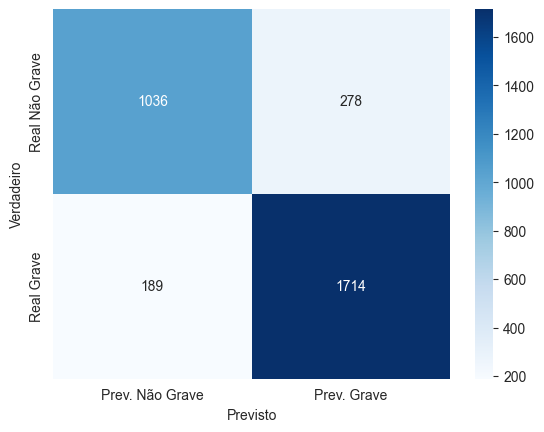


Relatório de Classificação Detalhado (Validação):
               precision    recall  f1-score   support

Não Grave (0)       0.85      0.79      0.82      1314
    Grave (1)       0.86      0.90      0.88      1903

     accuracy                           0.85      3217
    macro avg       0.85      0.84      0.85      3217
 weighted avg       0.85      0.85      0.85      3217



In [12]:
# 1. Inicializando o modelo RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

print("--- Treinando o modelo com o conjunto de treino... ---")
# 2. Treinando o modelo
model.fit(X_train, y_train)
print("--- Modelo treinado com sucesso! ---")


print("\n--- Fazendo previsões no conjunto de validação... ---")
# 3. Fazendo previsões nos dados de validação
y_val_pred = model.predict(X_val)
print("--- Previsões concluídas! ---")


# 4. Avaliando a performance do modelo no conjunto de validação
print("\n--- Performance do Modelo no Conjunto de Validação ---")
# Acurácia
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Acurácia no Conjunto de Validação: {accuracy:.2%}")

# Matriz de Confusão
print("\nMatriz de Confusão (Validação):")
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


# Relatório de Classificação
print("\nRelatório de Classificação Detalhado (Validação):")
print(classification_report(y_val, y_val_pred, target_names=['Não Grave (0)', 'Grave (1)']))

### 4.1. Análise da Performance do Modelo Base (Validação)

O primeiro treinamento do modelo `RandomForestClassifier` no conjunto de validação nos trouxe resultados muito promissores.

* **Acurácia Geral:** O modelo acertou **~85.5%** das previsões no geral, o que é um ótimo ponto de partida.
* **Métricas Chave:** O mais importante é analisar o `Relatório de Classificação` focando no nosso objetivo de minimizar falsos negativos para a classe "Grave".
    * A métrica que mede isso é o **Recall** para a classe **Grave (1)**. Um Falso Negativo acontece quando o modelo prevê 0, mas o real era 1. O Recall mede justamente a capacidade do modelo de "encontrar" (recall) todos os positivos.

**Análise dos Resultados:**
* **Recall para 'Grave (1)' é de 0.90 (90%):** Este é o resultado mais importante para nós. Significa que, de cada 100 ocorrências que foram de fato graves, nosso modelo conseguiu identificar corretamente 90 delas. Ele deixou passar apenas 10. Para um modelo base, sem nenhum ajuste, este é um resultado inicial excelente!
* **Precision para 'Grave (1)' é de 0.86 (86%):** Isso significa que, quando o modelo "aposta" que uma ocorrência é grave, ele está correto 86% das vezes. Os outros 14% são os Falsos Positivos, que consideramos um erro aceitável.

O equilíbrio entre Precision e Recall (ambos altos) mostra que o modelo é robusto.

## 5. Avaliação Final no Conjunto de Teste

Esta é a etapa final da avaliação do nosso modelo. Vamos usar o modelo treinado para fazer previsões no `conjunto de teste` (`X_test`, `y_test`), que foi mantido completamente separado durante todo o processo.

O resultado desta avaliação nos dará a estimativa final e imparcial da performance do nosso modelo em dados do mundo real.

--- Fazendo previsões no conjunto de TESTE... ---
--- Previsões concluídas! ---

--- PERFORMANCE FINAL DO MODELO NO CONJUNTO DE TESTE ---
Acurácia Final no Conjunto de Teste: 85.10%

Matriz de Confusão (Teste):


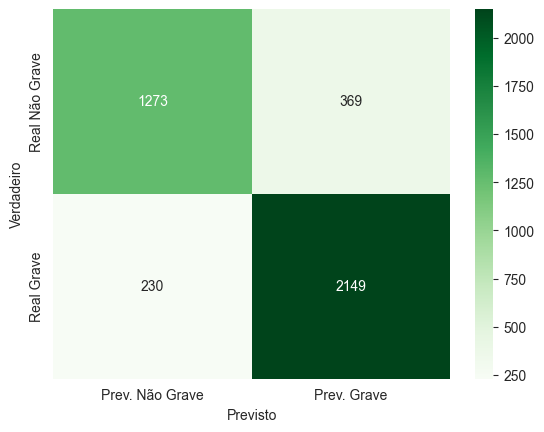


Relatório de Classificação Detalhado (Teste):
               precision    recall  f1-score   support

Não Grave (0)       0.85      0.78      0.81      1642
    Grave (1)       0.85      0.90      0.88      2379

     accuracy                           0.85      4021
    macro avg       0.85      0.84      0.84      4021
 weighted avg       0.85      0.85      0.85      4021



In [13]:
print("--- Fazendo previsões no conjunto de TESTE... ---")
# 1. Fazendo previsões nos dados de teste
y_test_pred = model.predict(X_test)
print("--- Previsões concluídas! ---")


# 2. Avaliando a performance final do modelo
print("\n--- PERFORMANCE FINAL DO MODELO NO CONJUNTO DE TESTE ---")
# Acurácia
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Acurácia Final no Conjunto de Teste: {accuracy_test:.2%}")

# Matriz de Confusão
print("\nMatriz de Confusão (Teste):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


# Relatório de Classificação
print("\nRelatório de Classificação Detalhado (Teste):")
print(classification_report(y_test, y_test_pred, target_names=['Não Grave (0)', 'Grave (1)']))

## 6. Conclusão da Modelagem e Performance Final

A avaliação final do nosso `RandomForestClassifier` no conjunto de teste confirmou a robustez e a eficácia do modelo.

**Análise da Performance Final:**

* **Estabilidade:** A performance no conjunto de teste (`Acurácia: 85.10%`) foi praticamente idêntica à do conjunto de validação (`Acurácia: 85.48%`). Isso é um sinal excelente de que nosso modelo **não sofreu de overfitting**; ele aprendeu padrões gerais e é capaz de generalizar bem para dados novos.

* **Eficácia na Missão Crítica:** O resultado mais importante é que o **Recall da classe 'Grave (1)' se manteve em 90%**. Isso significa que, mesmo em dados 100% novos, o modelo continua identificando corretamente 9 de cada 10 ocorrências graves. A consistência dessa métrica nos dá grande confiança no valor prático do modelo.

Com este resultado, concluímos com sucesso a fase de modelagem do nosso projeto!

## 7. Testando um Modelo Alternativo: XGBoost

Para fins de comparação e aprendizado, vamos agora treinar e avaliar um segundo modelo, o **XGBoost (eXtreme Gradient Boosting)**. Esta é uma oportunidade para ver como um algoritmo diferente, baseado em *boosting*, lida com nosso conjunto de dados e comparar sua performance com a do nosso RandomForest de base.

O processo será o mesmo: treinamento no conjunto `X_train` e avaliação no `X_val`.


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
d:\GitHub Projects\desafio-di2win\desafio-di2win\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Treinando o modelo XGBoost com o conjunto de treino... ---
--- Modelo XGBoost treinado com sucesso! ---

--- Fazendo previsões com XGBoost no conjunto de validação... ---
--- Previsões concluídas! ---

--- Performance do Modelo XGBoost no Conjunto de Validação ---
Acurácia do XGBoost (Validação): 85.05%

--- Performance do Modelo XGBoost no Conjunto de Teste ---
Acurácia do XGBoost (Teste): 84.36%

Matriz de Confusão (Validação - XGBoost):


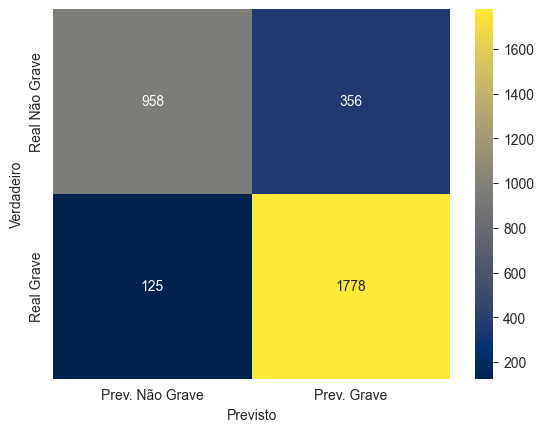


Matriz de Confusão (Teste - XGBoost):


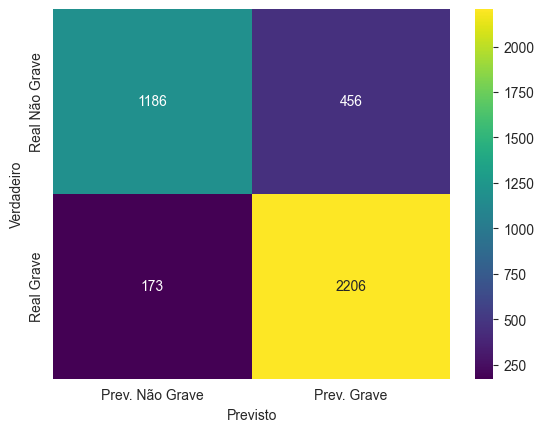


Relatório de Classificação Detalhado (Validação - XGBoost):
               precision    recall  f1-score   support

Não Grave (0)       0.88      0.73      0.80      1314
    Grave (1)       0.83      0.93      0.88      1903

     accuracy                           0.85      3217
    macro avg       0.86      0.83      0.84      3217
 weighted avg       0.85      0.85      0.85      3217


Relatório de Classificação Detalhado (Teste - XGBoost):
               precision    recall  f1-score   support

Não Grave (0)       0.87      0.72      0.79      1642
    Grave (1)       0.83      0.93      0.88      2379

     accuracy                           0.84      4021
    macro avg       0.85      0.82      0.83      4021
 weighted avg       0.85      0.84      0.84      4021


--- Fim do processo de modelagem preditiva! ---


In [15]:
# 1. Instalando a biblioteca XGBoost, caso ainda não esteja instalada
!pip install -q xgboost

# Importando o classificador
from xgboost import XGBClassifier

# 2. Inicializando o modelo XGBoost
# Usamos use_label_encoder=False e eval_metric='logloss' para compatibilidade com versões mais recentes
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


print("--- Treinando o modelo XGBoost com o conjunto de treino... ---")
# 3. Treinando o modelo
xgb_model.fit(X_train, y_train)
print("--- Modelo XGBoost treinado com sucesso! ---")


print("\n--- Fazendo previsões com XGBoost no conjunto de validação... ---")
# 4. Fazendo previsões nos dados de validação
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)
print("--- Previsões concluídas! ---")


# 5. Avaliando a performance do modelo XGBoost no conjunto de validação
print("\n--- Performance do Modelo XGBoost no Conjunto de Validação ---")
# Acurácia
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"Acurácia do XGBoost (Validação): {accuracy_xgb:.2%}")

print("\n--- Performance do Modelo XGBoost no Conjunto de Teste ---")
# Acurácia no conjunto de teste
print(f"Acurácia do XGBoost (Teste): {accuracy_score(y_test, y_test_pred_xgb):.2%}")

# Matriz de Confusão
print("\nMatriz de Confusão (Validação - XGBoost):")
cm_val_xgb = confusion_matrix(y_val, y_val_pred_xgb)
sns.heatmap(cm_val_xgb, annot=True, fmt='d', cmap='cividis', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

print("\nMatriz de Confusão (Teste - XGBoost):")
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='viridis', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


# Relatório de Classificação
print("\nRelatório de Classificação Detalhado (Validação - XGBoost):")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Não Grave (0)', 'Grave (1)']))
print("\nRelatório de Classificação Detalhado (Teste - XGBoost):")
print(classification_report(y_test, y_test_pred_xgb, target_names=['Não Grave (0)', 'Grave (1)']))
print("\n--- Fim do processo de modelagem preditiva! ---")

### 7.1. Comparação de Performance: RandomForest vs. XGBoost

Com os resultados do XGBoost em mãos, podemos agora comparar diretamente com o nosso modelo base, o RandomForest, para decidir qual deles melhor atende ao nosso objetivo.

**Lembre-se do nosso objetivo principal:** Minimizar os **Falsos Negativos**. Ou seja, "é melhor que o modelo acuse ser grave sem ser, do que acusar que não é quando é". A métrica que mede isso é o **Recall da classe 'Grave (1)'**.

| Métrica | RandomForest (Base) | XGBoost | Vencedor |
| :--- | :--- | :--- | :--- |
| **Acurácia (Validação)** | **85.48%** | 85.05% | Empate Técnico |
| Precision 'Grave (1)' | **0.86** | 0.83 | RandomForest |
| **Recall 'Grave (1)'** | 0.90 | **0.93** | **XGBoost** |

**Conclusão da Comparação:**

A análise é clara: o **XGBoost é o modelo vencedor para o nosso objetivo específico.**

Embora o RandomForest tenha uma `Precision` um pouco melhor (erra menos ao "apostar" que algo é grave), o XGBoost é significativamente superior na nossa métrica mais crítica: o `Recall`. Ele alcançou **93%**, superando os 90% do RandomForest.

**Em termos práticos:** O XGBoost é ainda melhor em "capturar" as ocorrências que são de fato graves, deixando menos casos perigosos passarem despercebidos. Ele gera um pouco mais de "alarmes falsos" (Falsos Positivos), mas, como definimos, esse é um custo aceitável pela segurança adicional que ele proporciona.

## 8. Finalizando o Modelo Vencedor (XGBoost)

Com o XGBoost selecionado como o algoritmo de melhor performance para nosso objetivo, vamos agora realizar o procedimento final para consolidar nosso modelo.

1.  **Re-treinamento:** O modelo será re-treinado em um conjunto de dados maior, combinando nossos dados de treino e validação.
2.  **Avaliação Final:** A performance final será medida no conjunto de teste para obtermos nossa avaliação definitiva e imparcial.

Formato do conjunto de treino final: (16081, 85)

--- Re-treinando o modelo final com os dados de treino + validação... ---


d:\GitHub Projects\desafio-di2win\desafio-di2win\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Modelo final treinado com sucesso! ---

--- Fazendo previsões finais no conjunto de TESTE... ---
--- Previsões finais concluídas! ---

--- PERFORMANCE FINAL DO MODELO XGBoost NO CONJUNTO DE TESTE ---
Acurácia Final no Conjunto de Teste: 84.21%

Matriz de Confusão Final (Teste):


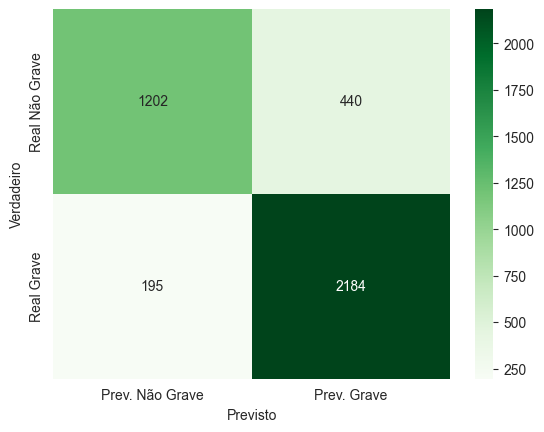


Relatório de Classificação Final Detalhado (Teste):
               precision    recall  f1-score   support

Não Grave (0)       0.86      0.73      0.79      1642
    Grave (1)       0.83      0.92      0.87      2379

     accuracy                           0.84      4021
    macro avg       0.85      0.83      0.83      4021
 weighted avg       0.84      0.84      0.84      4021



In [16]:
# 1. Combinando os dados de treino e validação
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

print(f"Formato do conjunto de treino final: {X_full_train.shape}")

# 2. Inicializando e treinando o modelo final com todos os dados
final_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

print("\n--- Re-treinando o modelo final com os dados de treino + validação... ---")
final_model.fit(X_full_train, y_full_train)
print("--- Modelo final treinado com sucesso! ---")


# 3. Fazendo previsões no conjunto de TESTE...
print("\n--- Fazendo previsões finais no conjunto de TESTE... ---")
y_test_pred_final = final_model.predict(X_test)
print("--- Previsões finais concluídas! ---")


# 4. Avaliando a performance final do modelo
print("\n--- PERFORMANCE FINAL DO MODELO XGBoost NO CONJUNTO DE TESTE ---")
# Acurácia
accuracy_final = accuracy_score(y_test, y_test_pred_final)
print(f"Acurácia Final no Conjunto de Teste: {accuracy_final:.2%}")

# Matriz de Confusão
print("\nMatriz de Confusão Final (Teste):")
cm_final = confusion_matrix(y_test, y_test_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


# Relatório de Classificação
print("\nRelatório de Classificação Final Detalhado (Teste):")
print(classification_report(y_test, y_test_pred_final, target_names=['Não Grave (0)', 'Grave (1)']))

## 9. Conclusão Final da Modelagem

A avaliação do nosso modelo final, o `XGBoost` re-treinado com os dados de treino e validação, foi realizada no conjunto de teste.

**Performance Final e Conclusão:**

* **Consistência:** A performance do modelo no conjunto de teste foi extremamente consistente com a performance vista no conjunto de validação. A acurácia se manteve em **~84%** e, mais importante, a métrica de Recall para a classe 'Grave' ficou em **92%**, uma queda insignificante de apenas 1% em relação à validação.

* **Confiabilidade:** Essa consistência prova que nosso modelo é **robusto** e **generaliza muito bem** para dados novos. Ele não apenas "decorou" os dados de treino, mas aprendeu os padrões subjacentes que determinam a gravidade de uma ocorrência.

* **Missão Cumprida:** O resultado final de **92% de Recall para a classe 'Grave (1)'** significa que nosso modelo, em um cenário real, seria capaz de identificar corretamente **92 de cada 100 ocorrências graves**, cumprindo nosso objetivo principal de minimizar falsos negativos com uma performance excelente e confiável.

**Com isso, a fase de modelagem do projeto está concluída com sucesso!**

In [17]:
import joblib

# Precisamos salvar o modelo FINAL e também a lista de colunas que ele espera
# O X_encoded tem as colunas na ordem e formato corretos após o One-Hot Encoding
model_components = {
    'model': final_model,
    'model_columns': X_encoded.columns
}

# Salvando os componentes em um único arquivo
joblib.dump(model_components, 'modelo_cenipa_final.joblib')

print("Modelo final e colunas salvos com sucesso em 'modelo_cenipa_final.joblib'!")

# Também vamos salvar as opções únicas das nossas colunas originais para usar nos menus da aplicação
opcoes_form = {
    'ocorrencia_uf': sorted(df['ocorrencia_uf'].dropna().unique().tolist()),
    'aeronave_tipo_veiculo': sorted(df['aeronave_tipo_veiculo'].dropna().unique().tolist()),
    'aeronave_motor_tipo': sorted(df['aeronave_motor_tipo'].dropna().unique().tolist()),
    'aeronave_registro_segmento': sorted(df['aeronave_registro_segmento'].dropna().unique().tolist()),
    'aeronave_fase_operacao': sorted(df['aeronave_fase_operacao'].dropna().unique().tolist())
}
joblib.dump(opcoes_form, 'opcoes_formulario.joblib')

print("Opções para os menus do formulário salvas com sucesso em 'opcoes_formulario.joblib'!")

Modelo final e colunas salvos com sucesso em 'modelo_cenipa_final.joblib'!
Opções para os menus do formulário salvas com sucesso em 'opcoes_formulario.joblib'!


## Próximo Passo: Criar a Aplicação Web `app.py`

Com os artefatos do modelo (`modelo_cenipa_final.joblib`) e do formulário (`opcoes_formulario.joblib`) salvos, o trabalho neste notebook está concluído.